In [37]:
using JSON

In [ ]:
using BenchmarkTools

A graph is usualy given by the list of links [(source, target), ...]. However, for the particular type of graph here, chains of nodes are considered. So the graph is given by chains of nodes: [[A1, A2, ...], ...].

In [4]:
using Plots

In [1]:
struct Graph
    chains
    nodes
end

Next we need a function which compute the system energy (and the forces?) for a given graph and a list of nodes coordinates. Folowing classical approach [Fruchterman and Reingold 1991](http://www.mathe2.uni-bayreuth.de/axel/papers/reingold:graph_drawing_by_force_directed_placement.pdf) there is an attractive force -between linked nodes- and repulsive forces between every nodes. In addition, here we want a torque at each node in a chain to rigidify the line. Maybe, a global gravity field would be required to densify the graph (keep disconected parts). 

$$
f_{attractive} = d^2/k \\
f_{repulsive} = -k^2/d
$$

ForceAtlas2:
https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0098679&type=printable

In [65]:
# Spring
function attractive_gradient(x1, y1, x2, y2)
    u = x2 - x1
    v = y2 - y1
    return (-u, -v, u, v)
    end;
function attractive_energy(x1, y1, x2, y2)
    u = x2 - x1
    v = y2 - y1
    return (u^2 + v^2)/2
    end;

# Elec
function repulsive_energy(x1, y1, x2, y2)
    u = x2 - x1
    v = y2 - y1
    return 1/sqrt(u^2 + v^2)
    end;

function repulsive_gradient(x1, y1, x2, y2)
    u = x2 - x1
    v = y2 - y1
    d = sqrt(u^2 + v^2)^3
    return (u/d, v/d, -u/d, -v/d)
    end;

# d/dx(-1/sqrt(x^2 + y^2)) = x/(x^2 + y^2)^(3/2)

In [66]:
repulsive_gradient(0., 0., 1., -1.)

(0.3535533905932737, -0.3535533905932737, -0.3535533905932737, 0.3535533905932737)

In [ ]:
@benchmark attractive_gradient(3.13, rand(), rand(), 4.242)

In [31]:
function graph_energy(coords, graph)
    E = 0
    # Attractive
    for chain in graph.chains
        for (n1, n2) in zip(chain[1:end-1], chain[2:end])
            i1, i2 = graph.nodes[n1], graph.nodes[n2]
            x1, y1 = coords[1, i1], coords[2, i1]
            x2, y2 = coords[1, i2], coords[2, i2]
            E += attractive_energy(x1, y1, x2, y2)
            end;
        end;
    
    # Repulsive
    # Todo: insert Barnes Hut here...
    for i in 1:length(graph.nodes)
        x1, y1 = coords[1, i], coords[2, i]
        for j in i+1:length(graph.nodes)
            x2, y2 = coords[1, j], coords[2, j]
            E += repulsive_energy(x1, y1, x2, y2)
            end;
        end;
    return E
    end;

In [8]:
@benchmark graph_energy(coords, graph)

LoadError: UndefVarError: @benchmark not defined

In [32]:
function graph_gradient!(G, coords, graph)
    fill!(G, 0.f0)
    # Attractive
    for chain in graph.chains
        for (n1, n2) in zip(chain[1:end-1], chain[2:end])
            i1, i2 = graph.nodes[n1], graph.nodes[n2]
            x1, y1 = coords[1, i1], coords[2, i1]
            x2, y2 = coords[1, i2], coords[2, i2]
            grad = attractive_gradient(x1, y1, x2, y2)
            G[1, i1] += grad[1]
            G[2, i1] += grad[2]
            G[1, i2] += grad[3]
            G[2, i2] += grad[4]
            end;
        end;
    
    # Repulsive
    # Todo: insert Barnes Hut here...
    for i in 1:length(graph.nodes)
        x1, y1 = coords[1, i], coords[2, i]
        for j in i+1:length(graph.nodes)
            x2, y2 = coords[1, j], coords[2, j]
            grad = repulsive_gradient(x1, y1, x2, y2)
            G[1, i] += grad[1]
            G[2, i] += grad[2]
            G[1, j] += grad[3]
            G[2, j] += grad[4]
            end;
        end;
    end;

Solve 

https://github.com/JuliaNLSolvers/Optim.jl

In [11]:
using(Optim)

In [75]:
# Load a graph
files = filter(x -> endswith(x, ".json"), readdir("json/"))

4-element Array{String,1}:
 "070506604.json"
 "087475936.json"
 "178303232.json"
 "197626394.json"

In [93]:
path = string("./json/", files[2])
data = read(path, String)
chains = JSON.parse( data, dicttype=Array{Array{String}});
sort!(chains, by=x->length(x), rev=true)
println(length(chains[1]))

33


In [92]:
# Simple graph
chains = [["A", "B", "R"], ["EEE", "C", "A", "T"], ["R", "EE", "C"]]

3-element Array{Array{String,1},1}:
 ["A", "B", "R"]       
 ["EEE", "C", "A", "T"]
 ["R", "EE", "C"]      

In [94]:
# Define the graph
nodes_list = unique(n for ch in chains for n in ch)
nodes = Dict( n=>k for (k, n) in enumerate(nodes_list) )
println(length(nodes), " nodes")
println(length(chains), " chains")
graph = Graph(chains, nodes);

151 nodes
18 chains


In [95]:
# init coords
N = length(graph.nodes)
radius = N/(2*pi)
coords = hcat([[radius*cos(k*2*pi/N); radius*sin(k*2*pi/N)] for k in 1:N]...);
# gradient
G = zeros(Float32, size(coords)...);

In [87]:
result = Optim.optimize(x->graph_energy(x, graph),
                        coords)

 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [2.04e+01, 1.84e-01, 2.00e+01,  ...]
    Minimum:   3.144992e+02

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [2.04e+01, 1.82e-01, 1.99e+01,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    22021


In [96]:
G = zeros(Float32, size(coords)...)
result = Optim.optimize(x->graph_energy(x, graph),
                        (G, x)->graph_gradient!(G, x, graph),
                        coords)

 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.16e+01, -4.25e+00, 4.07e+01,  ...]
    Minimum:   9.252237e+02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [2.40e+01, 1.00e+00, 2.39e+01,  ...]

 * Convergence measures
    |x - x'|               = 1.87e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.20e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.09e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.83e-16 ≰ 0.0e+00
    |g(x)|                 = 1.49e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   42  (vs limit Inf)
    Iterations:    556
    f(x) calls:    1656
    ∇f(x) calls:   1656


In [98]:
coords = result.minimizer;

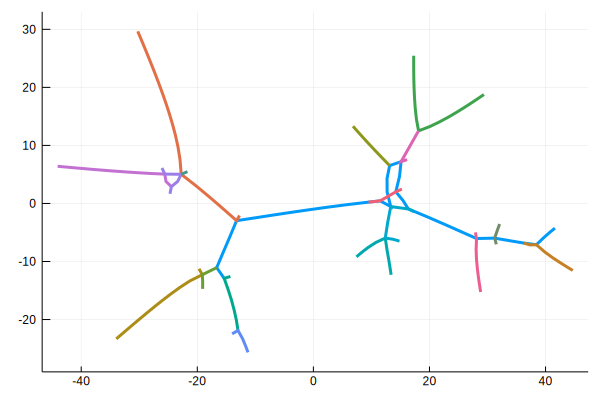

In [99]:
fig = plot(legend=false, aspect_ratio=:equal)
for chain in graph.chains
    idx = [graph.nodes[n] for n in chain]
    plot!(coords[1, idx], coords[2, idx], linewidth=3)
    #println(coords[idx, 1])
    end;
#scatter!(coords[1, :], coords[2, :], color="black")
fig

next:
- barnes Hut
- clarify nodes_index vs graph... structure, object? [ok]
- opti graph_energy (2d, no array?) [ok]
- is forwarddiff really fast ? [ok]
- opti only subset of the graph! ...
    - tree search optimin  vs thermal annealing?
- complex forces, time oriented field, or spiraling force